In [2]:
library(gdata)

In [12]:
rate_data <- read.xls('~/Dropbox/Projects_WORKING/BacteriaRates/all_METADATA/metadata_updated_rates.xlsx')

In [4]:
pass_drt <- rate_data$temp_stucture_degree>.5
rate_data <- data.frame(time = log10(rate_data$sampling_time[pass_drt]), 
                        rate = log10(rate_data$beast_genomic_rate[pass_drt]))

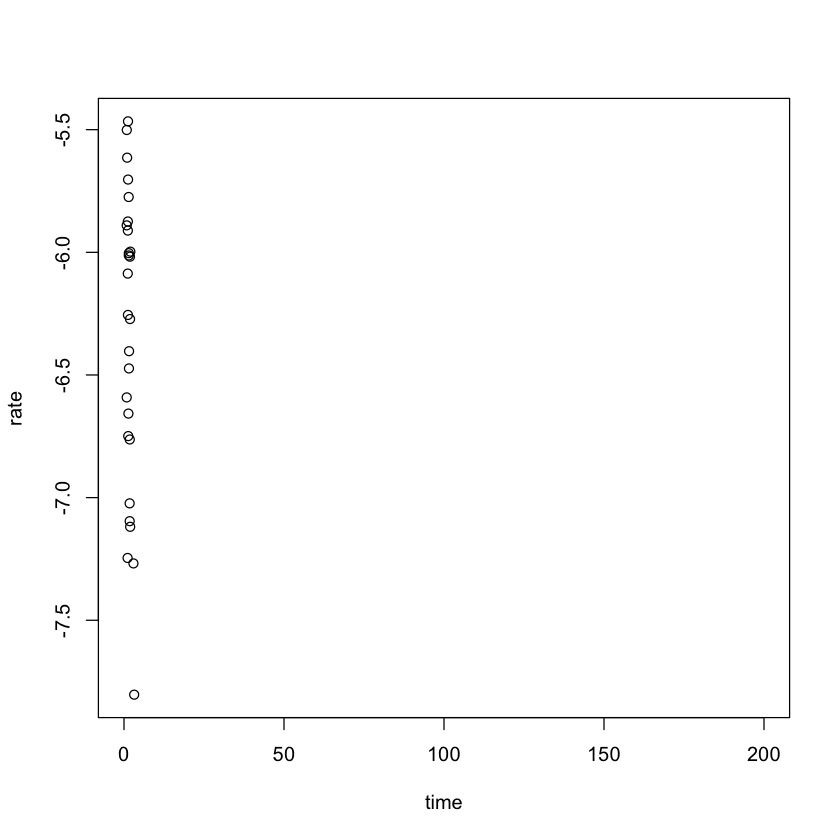

In [5]:
plot(rate_data, xlim = c(0, 200))

In [6]:
get_likelihood <- function(data, par){
    rate <- data$rate
    time <- data$time
    alpha <- par[1]
    beta <- par[2]
#    rate_fit <- (1 - alpha*(1-exp(1)^(-beta*time)  ))
    rate_fit <- alpha/(time^beta)
    return(-log(mean((rate_fit - rate)^2)))
}

get_prior <- 
function(par){

    log(dnorm(par[1], -5.9, 1))+log(dnorm(par[2], -0.18, 1))
}

prior <- get_prior(c(3, 4))
lik <- get_likelihood(rate_data, c(1, 1))
lik
prior

[1] -3.919422

[1] -50.17908

In [14]:
get_likelihood <- function(data, par){
    rate <- data$rate
    time <- data$time
    alpha <- par[1]
    beta <- par[2]
#    rate_fit <- (1 - alpha*(1-exp(1)^(-beta*time)  ))
    rate_fit <- alpha/(time^beta)
    -log(mean((rate_fit - rate)^2))
    }

In [15]:
#init mcmc
out_frame <- data.frame(step=1:1000, likelihood = rep(NA, 10000), prior = rep(NA, 10000),
                        posterior = rep(NA, 10000), alpha = rep(NA, 10000), 
                        beta = rep(NA, 10000) )

likelihood1 <- get_likelihood(rate_data, c(-5.9334230,-0.1789932))
prior1 <- get_prior(c(-5.9334230, -0.1789932))
posterior1 <- likelihood1+prior1

out_frame[1, 2:6] <- c(likelihood1, prior1, posterior1, -5.9334230, -0.1789932)
head(out_frame)

,step,likelihood,prior,posterior,alpha,beta
1,1,NaN,-1.838436,NaN,-5.933423,-0.1789932
2,2,NA,NA,NA,NA,NA
3,3,NA,NA,NA,NA,NA
4,4,NA,NA,NA,NA,NA
5,5,NA,NA,NA,NA,NA
6,6,NA,NA,NA,NA,NA


In [16]:
likelihood1 <- get_likelihood(rate_data, c(-5.9334230 -0.1789932))
get_likelihood <- function(data, par){
    rate <- data$rate
    time <- data$time
    alpha <- par[1]
    beta <- par[2]
#    rate_fit <- (1 - alpha*(1-exp(1)^(-beta*time)  ))
    rate_fit <- alpha/(time^beta)
    -log(mean((rate_fit - rate)^2))
    }
#    return(-log(mean((rate_fit - rate)^2)))

get_likelihood(rate_data, c(-5, -0.17))

[1] NaN

In [17]:
#run mcmc
accept <- 0
reject <- 0
for(i in 2:nrow(out_frame)){
    par_proposal <- as.numeric(out_frame[i-1, 5:6]+rnorm(2, 0, 0.05))
    prior_proposal <- get_prior(par_proposal)
    lik_proposal <- get_likelihood(rate_data, par_proposal)
    posterior_proposal <- prior_proposal+lik_proposal

    if(posterior_proposal > out_frame$posterior[i-1]){
        accept <- accept+1
        out_frame[i, 2:6] <- c(lik_proposal, prior_proposal, posterior_proposal, 
                               par_proposal)
    }else{
        eprev <- exp(out_frame$posterior[i-1])
        epnew <- exp(posterior_proposal)
        mh <- epnew/eprev
        if(mh > runif(1)){
            accept <- accept+1
            out_frame[i, 2:6] <- c(lik_proposal, prior_proposal, posterior_proposal, 
                                    par_proposal)
        }else{
            reject <- reject+1
            out_frame[i, 2:6] <- out_frame[i-1, 2:6]
        }
    }

    
}

ERROR: Error in if (posterior_proposal > out_frame$posterior[i - 1]) {: missing value where TRUE/FALSE needed


In [10]:
accept
reject

[1] 9205

[1] 794

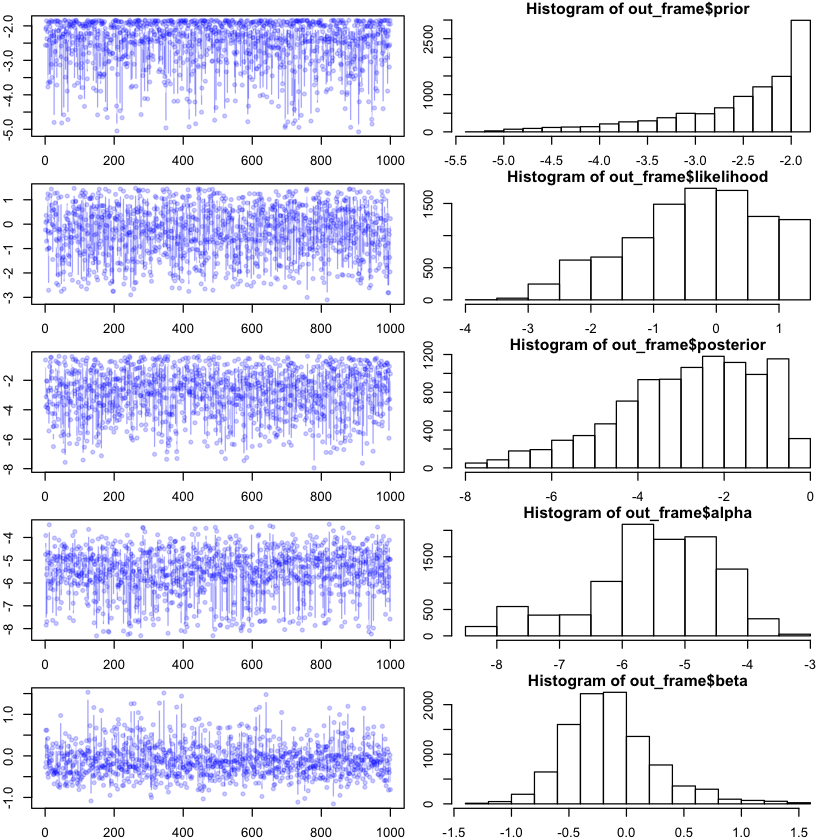

In [11]:
par(mfcol = c(5, 2))
par(mar = c(2, 2, 1, 1))
plot(sample(out_frame$prior, 1000), pch = 20, type = 'b', col = rgb(0, 0, 1, 0.2))
plot(sample(out_frame$likelihood, 1000), pch = 20, type = 'b', col = rgb(0, 0, 1, 0.2))
plot(sample(out_frame$posterior, 1000), pch = 20, type = 'b', col = rgb(0, 0, 1, 0.2))
plot(sample(out_frame$alpha, 1000), pch = 20, type = 'b', col = rgb(0, 0, 1, 0.2))
plot(sample(out_frame$beta, 1000), pch = 20, type = 'b', col = rgb(0, 0, 1, 0.2))

hist(out_frame$prior)
hist(out_frame$likelihood)
hist(out_frame$posterior)
hist(out_frame$alpha)
hist(out_frame$beta)



In [12]:
mcmc_hpds <- sapply(1:ncol(out_frame), function(x) quantile(out_frame[1000:ncol(out_frame), x], c(0.025, 0.975)))
mcmc_means <- sapply(1:ncol(out_frame), function(x) mean(out_frame[1000:ncol(out_frame), x]))
mcmc_hpds
mcmc_means

2.5%,30.8500000,-1.4528911,-3.4283160,-4.1267750,-7.6602465,-0.6362886
97.5%,975.1500000,1.4341160,-1.8405057,-0.4109076,-5.2890998,0.2381349


[1] 503.0000000   0.3808569  -2.0507343  -1.6698774  -6.0562773  -0.2241228

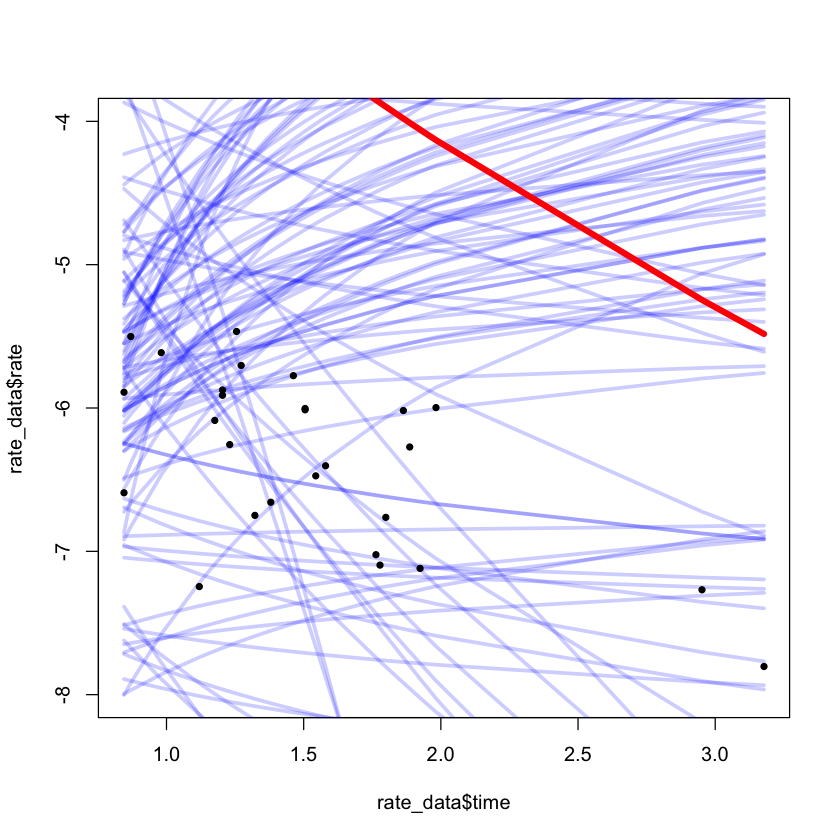

In [13]:
#fitted_vals <- (1 - mcmc_means[5]*(1-exp(1)^(-mcmc_means[6]*sort(rate_data$time))))
fitted_vals <- -2.74/(sort(rate_data$time)^-0.6)
plot(rate_data$time, rate_data$rate, type = 'n', ylim = c(-8, -4))
for(i in 1:100){
    n_samp <- sample(1:nrow(out_frame), 1)
    fitted_temp <- out_frame$alpha[n_samp]/(sort(rate_data$time)^-out_frame$beta[n_samp])
    lines(sort(rate_data$time), fitted_temp, lwd = 3, col = rgb(0, 0, 1, 0.2))
}

#plot(data_rates$time, data_rates$rate, ylim = c(-0.2, 0.2))
lines(sort(rate_data$time), fitted_vals,  col = rgb(1, 0, 0, 1), lwd = 5)
points(rate_data$time, rate_data$rate, pch = 20, col = rgb(0, 0, 0, 1))
#plot(sort(rate_data$time), fitted_vals)

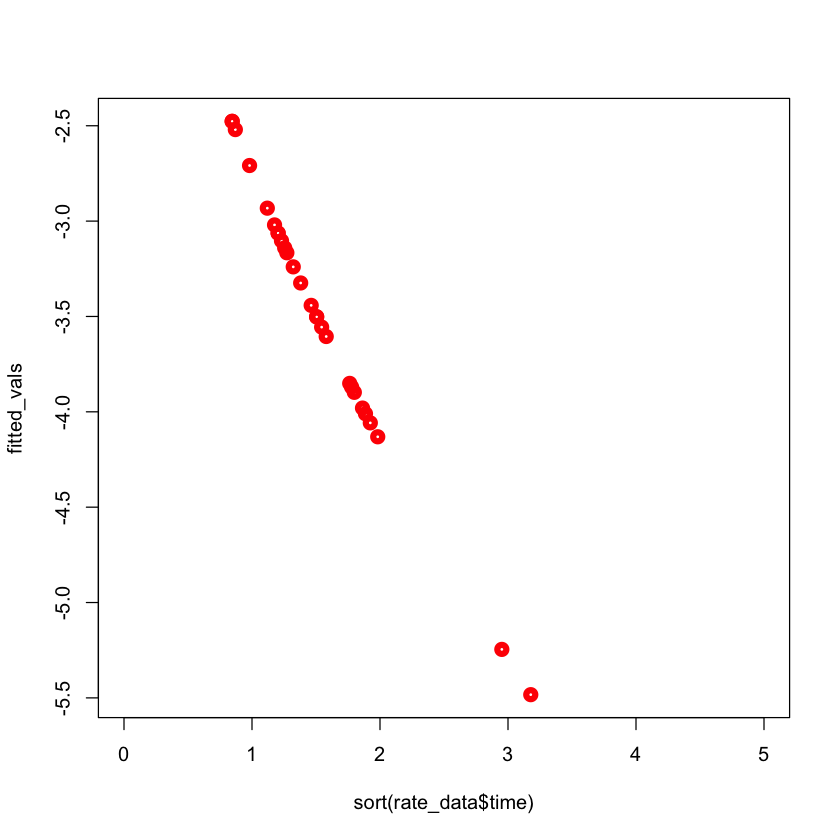

In [14]:
plot(sort(rate_data$time), fitted_vals,  col = rgb(1, 0, 0, 1), lwd = 5, xlim = c(0, 5))

In [18]:
get_likelihood <- function(data, par){
    rate <- data$rate
    time <- data$time
    alpha <- par[1]
    beta <- par[2]
#    rate_fit <- (1 - alpha*(1-exp(1)^(-beta*time)  ))
    rate_fit <- alpha/(time^beta)
    return(log(mean((rate_fit - rate)^2)))
}

In [19]:
result_mle <- optim(par = c(1, 1), get_likelihood, data = rate_data)
result_mle

ERROR: Error in optim(par = c(1, 1), get_likelihood, data = rate_data): function cannot be evaluated at initial parameters


ERROR: Error in vapply(seq_along(mapped), function(i) {: values must be length 1,
 but FUN(X[[5]]) result is length 0


$par
[1] -5.9334230 -0.1789932

$value
[1] -1.47268

$counts
function gradient 
     119       NA 

$convergence
[1] 0

$message
NULL


In [11]:
par_frame <- data.frame(alpha = rep(NA, 100), beta=rep(NA, 100))
#rate_data
meta_d

,time,rate
1,3.177825,-7.80337
2,1.119586,-7.246018
3,1.924279,-7.118956
4,1.778151,-7.096017
5,1.763428,-7.023468
6,1.799341,-6.763037
7,1.322219,-6.749192
8,1.380211,-6.657381
9,1.544068,-6.473366
10,1.579784,-6.403081


In [17]:
par_frame <- data.frame(alpha=rep(NA, 100), beta=rep(NA, 100))
for(i in 1:100){
    n_sample <- sample(1:nrow(rate_data), nrow(rate_data)-1)
    boot_data <- rate_data[n_sample, ]
    par_frame[i, ] <- optim(par = c(1, 1), get_likelihood, data = boot_data)$par
}

In [18]:
head(par_frame)
write.table(par_frame, file = '~/Dropbox/Projects_WORKING/BacteriaRates/all_METADATA/curve_fit_bootstrap.csv', row.names = F, sep = ',')

,alpha,beta
1,-5.93216,-0.172428
2,-5.976261,-0.1717744
3,-5.926568,-0.1748233
4,-5.918038,-0.1833499
5,-5.935245,-0.1841204
6,-5.934368,-0.1791189


In [19]:
fun_mle <- function(x) -5.9/(x^-0.17)

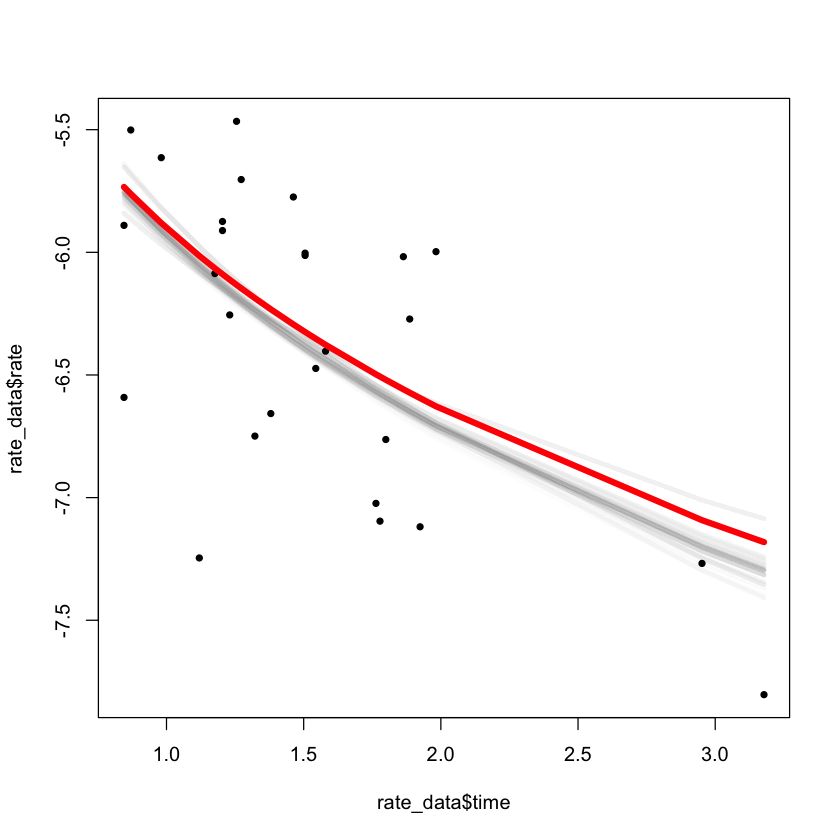

In [20]:
plot(rate_data$time, rate_data$rate, pch = 20)
for(i in 1:nrow(par_frame)){
    line_temp <- par_frame$alpha[i]/(sort(rate_data$time)^par_frame$beta[i])
    lines(sort(rate_data$time), line_temp, col = rgb(0, 0, 0, 0.01), lwd = 4)
}
lines(sort(rate_data$time), fun_mle(sort(rate_data$time)), col = 'red', lwd = 5)

In [21]:
pred_values <- -5.93/(rate_data$time^-0.179)

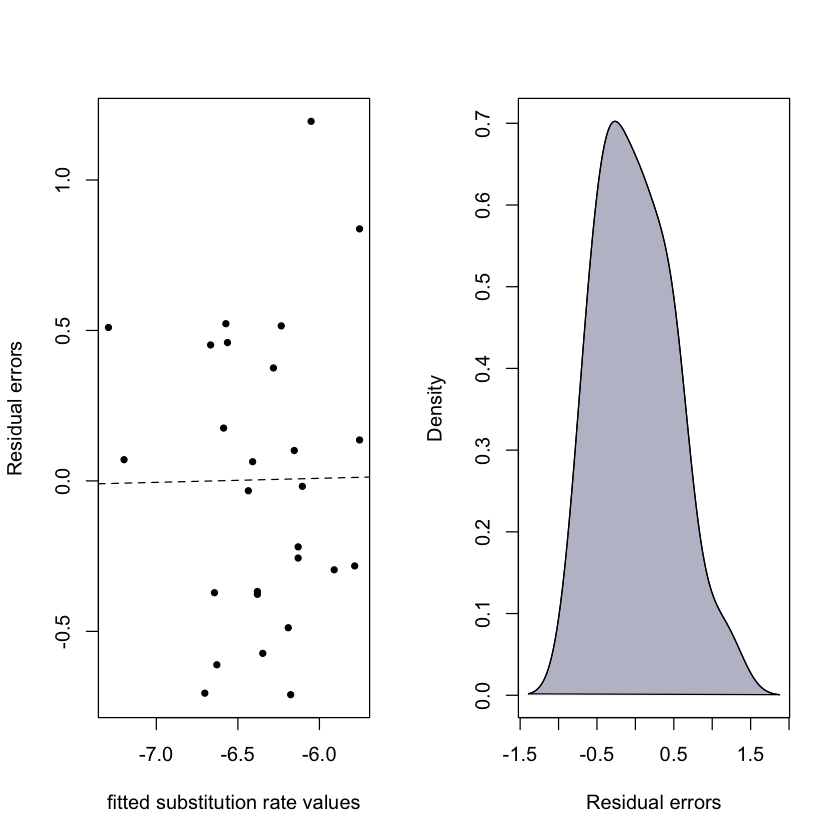

In [22]:
#pdf('~/Dropbox/Projects_WORKING/BacteriaRates/all_METADATA/residuals_plot.pdf', useDingbats = F,
#   width = 10, height = 5)
par(mfrow = c(1, 2))
plot(pred_values, pred_values - rate_data$rate, pch = 20, ylab = 'Residual errors', xlab = 'fitted substitution rate values')
y <- pred_values - rate_data$rate 
abline(lm(y~pred_values), lty = 2)
dens_vals <- density(pred_values - rate_data$rate)
plot(dens_vals, main = '', xlab = 'Residual errors')
polygon(dens_vals, col = rgb(0,0,0.3,0.3))
#hist(pred_values - rate_data$rate, main = '', xlab = 'Residual errors', breaks = 5, col = rgb(0, 0, 0, 0.5))
#dev.off()

In [25]:

summary(lm(y ~ rate_data$time))


Call:
lm(formula = y ~ rate_data$time)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.72519 -0.37509 -0.00926  0.40546  1.20568 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)
(Intercept)    -0.05046    0.28605  -0.176    0.861
rate_data$time  0.03544    0.17569   0.202    0.842

Residual standard error: 0.4972 on 25 degrees of freedom
Multiple R-squared:  0.001625,	Adjusted R-squared:  -0.03831 
F-statistic: 0.04069 on 1 and 25 DF,  p-value: 0.8418
